<a href="https://colab.research.google.com/github/MoeinDSP/Bittensor_Reddit_Dataset_NLP_Pipeline/blob/main/Models/3_Training_Models_Transformers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**1- Install and Import Libraries**

In [1]:
!pip install datasets
!pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 23.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 13.8 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2025.3.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which i

In [2]:
import torch
import random
import datasets
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from evaluate import load
from datasets import Dataset
from transformers import Trainer
from transformers import TrainerCallback
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import BertTokenizerFast, BertConfig, BertForSequenceClassification, Trainer, TrainingArguments

**2- Data Loading**

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import os

path = '/content/drive/MyDrive/Reddit_dataset'

os.chdir(f'{path}')
os.getcwd()

'/content/drive/.shortcut-targets-by-id/1uYfTSnfokWDeAv9-_LyZu5MGDLuJlF_n/Reddit_dataset'

**3- Prepare dataset to train**

In [5]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(42)

In [6]:
# Load dataset
df = pd.read_csv("/content/drive/MyDrive/Reddit_dataset/Finance_50K_Cleaned_Labels.csv")
df.drop(['label', 'text'], axis=1, inplace=True)
df = df.rename(columns={'preprocessed_text': 'text', 'clean_label': 'label'})

# Encode labels
le = LabelEncoder()
df['label'] = le.fit_transform(df['label'])

train_df, test_df = train_test_split(df[['text', 'label']], test_size=0.2, stratify=df['label'], random_state=42)

train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)

In [7]:
# Tokenizer
tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")
def tokenize_function(example):
    return tokenizer(example["text"], padding="max_length", truncation=True, max_length=128)

tokenized_train = train_dataset.map(tokenize_function, batched=True)
tokenized_test = test_dataset.map(tokenize_function, batched=True)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Map:   0%|          | 0/39816 [00:00<?, ? examples/s]

Map:   0%|          | 0/9954 [00:00<?, ? examples/s]

**4- Model Implementation**

In [8]:
class TrainingStatsCollector(TrainerCallback):
    def __init__(self, train_dataset, tokenizer, model, device='cuda' if torch.cuda.is_available() else 'cpu', bs=64):
        self.train_dataset = train_dataset
        self.tokenizer = tokenizer
        self.model = model.to(device)
        self.device = device
        self.bs = bs
        self.train_loss = []
        self.eval_loss = []
        self.train_acc = []
        self.eval_acc = []

    def compute_train_accuracy(self):
        self.model.eval()
        all_preds, all_labels = [], []
        for i in range(0, len(self.train_dataset), self.bs):  # Manual batching
            batch = self.train_dataset[i:i+self.bs]
            texts = batch['text']
            labels = batch['label']
            encodings = self.tokenizer(texts, truncation=True, padding=True, max_length=128, return_tensors="pt").to(self.device)
            labels_tensor = torch.tensor(labels).to(self.device)
            with torch.no_grad():
                outputs = self.model(**encodings)
                preds = torch.argmax(outputs.logits, dim=1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels_tensor.cpu().numpy())
        correct = np.sum(np.array(all_preds) == np.array(all_labels))
        return correct / len(self.train_dataset)

    def on_log(self, args, state, control, logs=None, **kwargs):
        if logs is None:
            return
        # Safely append available values
        if "loss" in logs:
            self.train_loss.append(logs["loss"])

    def on_evaluate(self, args, state, control, metrics=None, **kwargs):
        if metrics is None:
            return
        if "eval_loss" in metrics:
            self.eval_loss.append(metrics["eval_loss"])
        if "eval_accuracy" in metrics:
            self.eval_acc.append(metrics["eval_accuracy"])
        train_accuracy = self.compute_train_accuracy()
        self.train_acc.append(train_accuracy)

In [9]:
# Metric
accuracy = load("accuracy")
def compute_metrics(p):
    return accuracy.compute(predictions=p.predictions.argmax(axis=1), references=p.label_ids)

In [10]:
# Model config
config = BertConfig(
    vocab_size=tokenizer.vocab_size,
    num_labels=3
)

model = BertForSequenceClassification(config)

# Training
training_args = TrainingArguments(
    output_dir="./bert_scratch",
    eval_strategy="epoch",
    save_strategy="epoch",                 # Save checkpoint each epoch
    save_total_limit=1,                    # Keep only one checkpoint
    load_best_model_at_end=True,           # Reload best model after training
    metric_for_best_model="eval_loss",     # Use eval_loss to select best
    greater_is_better=False,               # Lower eval_loss is better
    learning_rate=2e-5,
    per_device_train_batch_size=128,
    per_device_eval_batch_size=128,
    num_train_epochs=5,
    weight_decay=0.01,
    logging_dir='./logs'
)

stats_callback = TrainingStatsCollector(train_dataset=train_dataset, tokenizer=tokenizer, model=model, bs=128)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[stats_callback]
)

<ipython-input-10-6a12b4723f89>:28: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


**5- Train and Evaluation**

In [11]:
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: moeintaheri78 (moeintaheri78-politecnico-di-milano) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.935823,0.552843
2,0.979700,0.988516,0.539783
3,0.979700,0.887009,0.582078
4,0.825500,0.854827,0.601266


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.935823,0.552843
2,0.979700,0.988516,0.539783
3,0.979700,0.887009,0.582078
4,0.825500,0.854827,0.601266
5,0.758200,0.843933,0.620354


TrainOutput(global_step=1560, training_loss=0.8497053733238807, metrics={'train_runtime': 5640.5523, 'train_samples_per_second': 35.294, 'train_steps_per_second': 0.277, 'total_flos': 1.309515480032256e+16, 'train_loss': 0.8497053733238807, 'epoch': 5.0})

**6- Results**

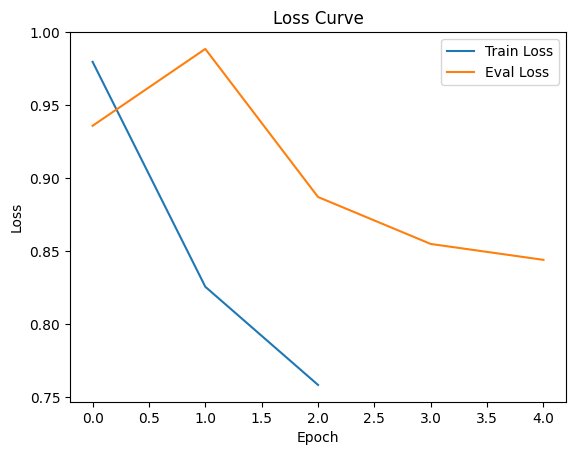

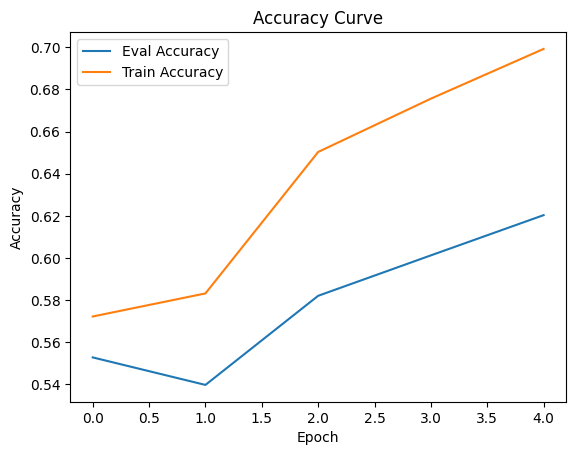

In [12]:
# Plot losses
plt.figure()
plt.plot(stats_callback.train_loss, label='Train Loss')
plt.plot(stats_callback.eval_loss, label='Eval Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()
plt.savefig("plots/bert_scratch_loss.png")

# Plot accuracy
plt.figure()
plt.plot(stats_callback.eval_acc, label='Eval Accuracy')
plt.plot(stats_callback.train_acc, label='Train Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Curve')
plt.legend()
plt.savefig("plots/bert_scratch_accuracy.png")

Classification Report:
              precision    recall  f1-score   support

    Negative       0.63      0.64      0.63      3595
     Neutral       0.65      0.68      0.66      4549
    Positive       0.53      0.44      0.48      1810

    accuracy                           0.62      9954
   macro avg       0.60      0.59      0.59      9954
weighted avg       0.62      0.62      0.62      9954



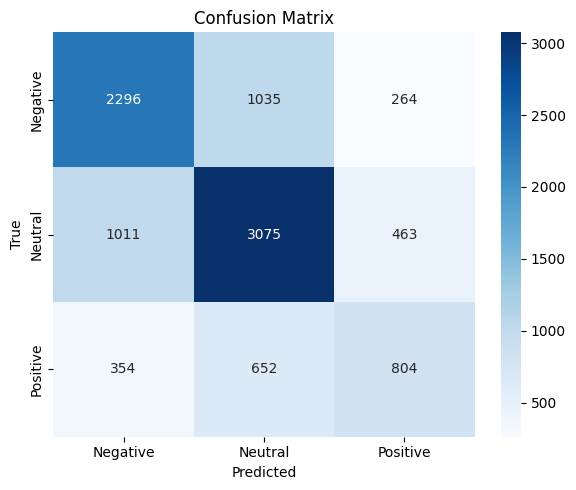

In [13]:
# model_name_or_path = "./bert_scratch"  # path to fine-tuned model
# tokenizer = AutoTokenizer.from_pretrained(model_name_or_path)
# model = AutoModelForSequenceClassification.from_pretrained(model_name_or_path)
model.eval()

trainer = Trainer(model=model)
preds = trainer.predict(tokenized_test)
y_pred = np.argmax(preds.predictions, axis=1)
y_true = preds.label_ids

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=le.classes_))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.savefig("plots/bert_scratch_confmat_testset.png")

In [19]:
def predict_unlabeled_texts(texts):
    encodings = tokenizer(texts, padding=True, truncation=True, max_length=128, return_tensors="pt")

    # Move encodings to the same device as the model
    encodings = {key: value.to(model.device) for key, value in encodings.items()}

    with torch.no_grad():
        outputs = model(**encodings)
        preds = torch.argmax(outputs.logits, dim=1).cpu().numpy()
    labels = le.inverse_transform(preds)
    for text, label in zip(texts, labels):
        print(f"Text: {text}\nPredicted Sentiment: {label}\n")

# Example usage
unlabeled_texts = [
    "Markets rallied today on strong earnings reports",
    "The economic outlook remains uncertain",
    "Tech stocks soared after a positive forecast",
    "I love save my money to become a rich man",
    "America had a bad economic experience during the Trump presidency"
]
predict_unlabeled_texts(unlabeled_texts)

Text: Markets rallied today on strong earnings reports
Predicted Sentiment: Neutral

Text: The economic outlook remains uncertain
Predicted Sentiment: Neutral

Text: Tech stocks soared after a positive forecast
Predicted Sentiment: Neutral

Text: I love save my money to become a rich man
Predicted Sentiment: Positive

Text: America had a bad economic experience during the Trump presidency
Predicted Sentiment: Negative



In [16]:
import shutil
from IPython.display import FileLink

# Step 1: Create a directory and then zip the folder containing the plots (replace 'plots' with your folder name)
!mkdir plots_Transformers # Create a directory if it doesn't exist
shutil.make_archive('plots_Transformers', 'zip', 'plots')  # change 'plots_Transformers' to 'plots'

# Step 2: Provide a download link
FileLink('plots_Transformers.zip')

/content/drive/.shortcut-targets-by-id/1uYfTSnfokWDeAv9-_LyZu5MGDLuJlF_n/Reddit_dataset/plots_Transformers.zip

**7- Fine-tuning**

In [21]:
model_name = "ProsusAI/finbert"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3)

def tokenize_function(example):
    return tokenizer(example['text'], truncation=True, padding="max_length", max_length=128)

tokenized_train = train_dataset.map(tokenize_function, batched=True)
tokenized_test = test_dataset.map(tokenize_function, batched=True)

training_args = TrainingArguments(
    output_dir="./finbert_finetuned",
    eval_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=1,                    # Keep only one checkpoint
    load_best_model_at_end=True,           # Reload best model after training
    greater_is_better=False,               # Lower eval_loss is better
    learning_rate=2e-5,
    per_device_train_batch_size=128,
    per_device_eval_batch_size=128,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir="./logs",
    metric_for_best_model="eval_loss"
)

stats_callback = TrainingStatsCollector(train_dataset=train_dataset, tokenizer=tokenizer, model=model, bs=128)


trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[stats_callback]
)

Map:   0%|          | 0/39816 [00:00<?, ? examples/s]

Map:   0%|          | 0/9954 [00:00<?, ? examples/s]

<ipython-input-21-0058c7c76391>:30: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [22]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.699706,0.698815
2,0.765400,0.681587,0.708358
3,0.765400,0.686556,0.711171


TrainOutput(global_step=936, training_loss=0.6735900161612747, metrics={'train_runtime': 3370.6959, 'train_samples_per_second': 35.437, 'train_steps_per_second': 0.278, 'total_flos': 7857092880193536.0, 'train_loss': 0.6735900161612747, 'epoch': 3.0})

In [31]:
stats_callback.train_loss = [None, 0.765400, 0.765400]

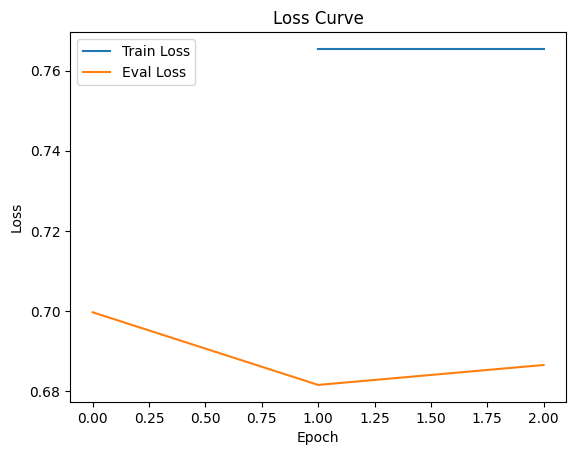

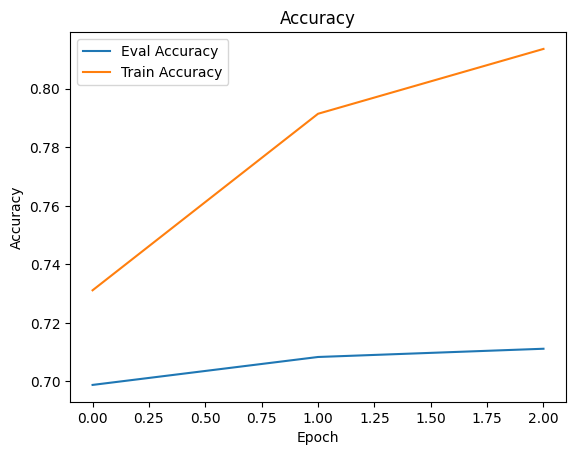

In [32]:
os.makedirs("plots", exist_ok=True)

plt.figure()
plt.plot(stats_callback.train_loss, label="Train Loss")
plt.plot(stats_callback.eval_loss, label="Eval Loss")
plt.title("Loss Curve")
plt.xlabel("Epoch")
plt.ylabel('Loss')
plt.legend()
plt.savefig("plots/finbert_loss.png")

plt.figure()
# Access eval_acc instead of eval_accuracy
plt.plot(stats_callback.eval_acc, label="Eval Accuracy")
plt.plot(stats_callback.train_acc, label="Train Accuracy")
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel('Accuracy')
plt.legend()
plt.savefig("plots/finbert_accuracy.png")




Classification Report:
              precision    recall  f1-score   support

    Negative       0.70      0.75      0.72      3595
     Neutral       0.75      0.70      0.72      4549
    Positive       0.64      0.66      0.65      1810

    accuracy                           0.71      9954
   macro avg       0.69      0.70      0.70      9954
weighted avg       0.71      0.71      0.71      9954



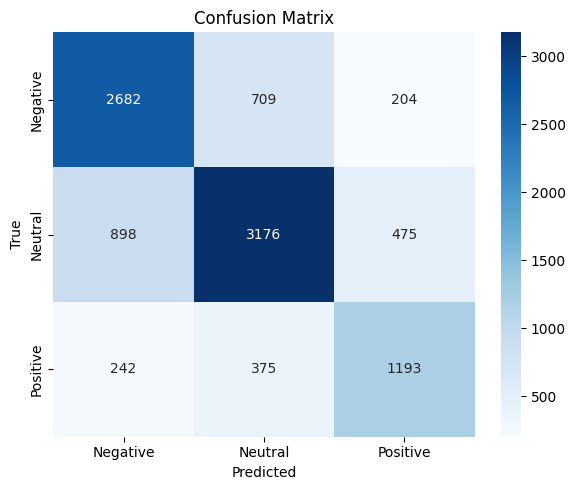

In [24]:
preds = trainer.predict(tokenized_test)
y_pred = np.argmax(preds.predictions, axis=1)
y_true = preds.label_ids

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=le.classes_))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.savefig("plots/finbert_confusion_matrix.png")

In [25]:
def predict_unlabeled_texts(texts):
    encodings = tokenizer(texts, padding=True, truncation=True, max_length=128, return_tensors="pt")

    # Move encodings to the same device as the model
    encodings = {key: value.to(model.device) for key, value in encodings.items()}

    with torch.no_grad():
        outputs = model(**encodings)
        preds = torch.argmax(outputs.logits, dim=1).cpu().numpy()
    labels = le.inverse_transform(preds)
    for text, label in zip(texts, labels):
        print(f"Text: {text}\nPredicted Sentiment: {label}\n")

# Example usage
unlabeled_texts = [
    "Markets rallied today on strong earnings reports",
    "The economic outlook remains uncertain",
    "Tech stocks soared after a positive forecast",
    "I love save my money to become a rich man",
    "America had a bad economic experience during the Trump presidency"
]
predict_unlabeled_texts(unlabeled_texts)

Text: Markets rallied today on strong earnings reports
Predicted Sentiment: Positive

Text: The economic outlook remains uncertain
Predicted Sentiment: Neutral

Text: Tech stocks soared after a positive forecast
Predicted Sentiment: Negative

Text: I love save my money to become a rich man
Predicted Sentiment: Positive

Text: America had a bad economic experience during the Trump presidency
Predicted Sentiment: Negative



In [33]:
import shutil
from IPython.display import FileLink

# Step 1: Create a directory and then zip the folder containing the plots (replace 'plots' with your folder name)
!mkdir plots_Transformers # Create a directory if it doesn't exist
shutil.make_archive('plots_Transformers_fine-tuned', 'zip', 'plots')

# Step 2: Provide a download link
FileLink('plots_Transformers_fine-tuned.zip')

mkdir: cannot create directory ‘plots_Transformers’: File exists


/content/drive/.shortcut-targets-by-id/1uYfTSnfokWDeAv9-_LyZu5MGDLuJlF_n/Reddit_dataset/plots_Transformers_fine-tuned.zip